# Régression Linéaire vs Réseau de Neurones (Keras)

Objectif : entraîner **une régression** sur ton dataset (clients + transactions) et comparer :

- ✅ **Baseline** : Régression linéaire (scikit-learn)
- ✅ **NN** : Réseau de neurones dense (TensorFlow/Keras)

## Hypothèse de démo
On prédit une variable continue, par défaut : **`avg_transaction_value`**.

Tu peux changer la cible en modifiant la variable `TARGET`.


## 0) Installation 

```bash
pip install -U tensorflow scikit-learn pandas matplotlib
```


In [21]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)


## 1) Charger le dataset

### Option A (recommandée)
Sauvegarde ton dataset dans un fichier : `customer_dataset.csv` puis utilise ce chargement.

### Option B
Colle le CSV dans une variable multi-ligne (utile pour mini-samples).


In [22]:
CSV_PATH = 'retail_data.csv' 
df = pd.read_csv(CSV_PATH)
print('✅ Dataset chargé depuis:', CSV_PATH)

✅ Dataset chargé depuis: retail_data.csv


In [23]:
print('Shape:', df.shape)
display(df.head(3))

Shape: (1000000, 78)


,customer_id,age,gender,income_bracket,loyalty_program,membership_years,churned,marital_status,number_of_children,education_level,...,distance_to_store,holiday_season,season,weekend,customer_support_calls,email_subscriptions,app_usage,website_visits,social_media_engagement,days_since_last_purchase
0,1,56,Other,High,No,0,No,Divorced,3,Bachelor's,...,33.21,No,Spring,Yes,5,No,High,30,High,40
1,2,69,Female,Medium,No,2,No,Married,2,PhD,...,62.56,No,Summer,Yes,6,No,High,40,Medium,338
2,3,46,Female,Low,No,5,No,Married,3,Bachelor's,...,83.04,Yes,Winter,Yes,2,Yes,Low,89,Medium,61


## 2) Choisir la cible (régression)

On choisit une variable numérique continue.

Exemples :
- `avg_transaction_value`
- `avg_purchase_value`
- `total_sales`
- `days_since_last_purchase`


In [25]:
TARGET = 'avg_transaction_value'

print('Cible:', TARGET)
print('Type:', df[TARGET].dtype)
display(df[[TARGET]].describe())

Cible: avg_transaction_value
Type: float64


,avg_transaction_value
count,1000000.000000
mean,255.115768
std,141.430014
min,10.000000
25%,132.510000
50%,255.230000
75%,377.670000
max,500.000000


## 3) Sélection pro des features (démo lisible)

Ton dataset est très grand. Pour une **démo pro**, on fait volontairement un sous-ensemble :
- **features comportementales**
- **features profil**
- quelques variables de contexte

On exclut : IDs, noms de produit, timestamps trop détaillés, etc.


In [26]:
DROP_ALWAYS = [
    'customer_id', 'transaction_id', 'product_id', 'promotion_id',
    'product_name', 'transaction_date', 'last_purchase_date',
    'product_manufacture_date', 'product_expiry_date',
]

# Features proposées (tu peux ajuster)
CANDIDATE_FEATURES = [
    # Numériques
    'age', 'membership_years', 'number_of_children',
    'online_purchases', 'in_store_purchases',
    'avg_items_per_transaction', 'purchase_frequency',
    'customer_support_calls', 'days_since_last_purchase',
    'distance_to_store',

    # Catégorielles
    'gender', 'income_bracket', 'loyalty_program',
    'marital_status', 'education_level',
]

# Ne garder que ce qui existe réellement dans le dataset
existing = [c for c in CANDIDATE_FEATURES if c in df.columns]
missing = [c for c in CANDIDATE_FEATURES if c not in df.columns]

if missing:
    print('⚠️ Colonnes absentes (ignorées):', missing)

df_model = df.copy()
for c in DROP_ALWAYS:
    if c in df_model.columns:
        df_model = df_model.drop(columns=[c])

# Garder uniquement features + target
keep_cols = existing + [TARGET]
df_model = df_model[keep_cols].copy()

print('Shape model:', df_model.shape)
display(df_model.head(3))

Shape model: (1000000, 16)


,age,membership_years,number_of_children,online_purchases,in_store_purchases,avg_items_per_transaction,purchase_frequency,customer_support_calls,days_since_last_purchase,distance_to_store,gender,income_bracket,loyalty_program,marital_status,education_level,avg_transaction_value
0,56,0,3,55,86,8.64,Weekly,5,40,33.21,Other,High,No,Divorced,Bachelor's,171.83
1,69,2,2,48,2,9.60,Daily,6,338,62.56,Female,Medium,No,Married,PhD,20.18
2,46,5,3,16,45,1.55,Weekly,2,61,83.04,Female,Low,No,Married,Bachelor's,55.17


## 4) Nettoyage et typage

On harmonise les valeurs type `Yes/No` (si présentes), et on s'assure que la cible est bien numérique.


In [27]:
def yes_no_to_binary(s: pd.Series) -> pd.Series:
    # Convertit Yes/No -> 1/0 si applicable
    if s.dtype == object:
        vals = set(str(v).strip() for v in s.dropna().unique())
        if vals.issubset({'Yes', 'No'}):
            return s.map({'Yes': 1, 'No': 0})
    return s

for col in df_model.columns:
    df_model[col] = yes_no_to_binary(df_model[col])

# Cible en numérique (au cas où)
df_model[TARGET] = pd.to_numeric(df_model[TARGET], errors='coerce')

print('NaN dans la cible:', df_model[TARGET].isna().sum())
df_model = df_model.dropna(subset=[TARGET]).reset_index(drop=True)

print('✅ Après nettoyage:', df_model.shape)

NaN dans la cible: 0
✅ Après nettoyage: (1000000, 16)


## 5) Split Train/Test

On sépare les données pour évaluer proprement.


In [28]:
X = df_model.drop(columns=[TARGET])
y = df_model[TARGET].astype(float)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)

print('Train:', X_train.shape, 'Test:', X_test.shape)
display(X_train.head(2))

Train: (800000, 15) Test: (200000, 15)


,age,membership_years,number_of_children,online_purchases,in_store_purchases,avg_items_per_transaction,purchase_frequency,customer_support_calls,days_since_last_purchase,distance_to_store,gender,income_bracket,loyalty_program,marital_status,education_level
566853,26,7,4,29,64,9.21,Monthly,9,37,2.81,Male,Low,0,Married,Bachelor's
382311,66,6,2,7,57,8.33,Weekly,17,329,1.68,Other,Low,0,Single,PhD


## 6) Préprocessing (pro)

On utilise un `ColumnTransformer` :
- Numériques: imputation + standardisation
- Catégorielles: imputation + one-hot


In [13]:
numeric_features = [c for c in X_train.columns if pd.api.types.is_numeric_dtype(X_train[c])]
categorical_features = [c for c in X_train.columns if c not in numeric_features]

print('Numériques:', numeric_features)
print('Catégorielles:', categorical_features)

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)

X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)

print('✅ Shapes après preprocessing:')
print('  X_train_proc:', X_train_proc.shape)
print('  X_test_proc :', X_test_proc.shape)

Numériques: ['age', 'membership_years', 'number_of_children', 'online_purchases', 'in_store_purchases', 'avg_items_per_transaction', 'customer_support_calls', 'days_since_last_purchase', 'distance_to_store', 'loyalty_program']
Catégorielles: ['purchase_frequency', 'gender', 'income_bracket', 'marital_status', 'education_level']
✅ Shapes après preprocessing:
  X_train_proc: (800000, 27)
  X_test_proc : (200000, 27)


## 7) On essai la  Régression Linéaire dans un premier temps

On entraîne une régression linéaire sur les features prétraitées.


In [14]:
linreg = LinearRegression()
linreg.fit(X_train_proc, y_train)

pred_lr = linreg.predict(X_test_proc)

mae_lr = mean_absolute_error(y_test, pred_lr)
mse_lr = mean_squared_error(y_test, pred_lr)
r2_lr = r2_score(y_test, pred_lr)

print('📌 Régression linéaire — Résultats')
print('  MAE:', round(mae_lr, 4))
print('  MSE:', round(mse_lr, 4))
print('  R² :', round(r2_lr, 4))

📌 Régression linéaire — Résultats
  MAE: 122.432
  MSE: 19981.1926
  R² : -0.0001


## 8) Réseau de neurones (Keras) — Régression

Architecture simple, efficace pour une démo :

- Dense(64) ReLU
- Dense(32) ReLU
- Dense(1) sortie linéaire

On utilise :
- `EarlyStopping` (évite l'overfit)
- `ReduceLROnPlateau` (stabilise la descente)


In [ ]:
# Convertir en float32 dense
def to_dense_float32(X):
    if hasattr(X, 'toarray'):
        X = X.toarray()
    return np.asarray(X).astype('float32')

X_train_nn = to_dense_float32(X_train_proc)
X_test_nn = to_dense_float32(X_test_proc)
y_train_nn = y_train.astype('float32').to_numpy()
y_test_nn = y_test.astype('float32').to_numpy()

input_dim = X_train_nn.shape[1]

nn = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

nn.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='mse',
    metrics=['mae']
)

callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
]

history = nn.fit(
    X_train_nn, y_train_nn,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/200
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 21s 1ms/step - loss: 20505.5879 - mae: 123.5750 - val_loss: 19954.1250 - val_mae: 122.2986 - learning_rate: 0.0010
Epoch 2/200
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 21s 1ms/step - loss: 20086.9609 - mae: 122.7098 - val_loss: 19949.7344 - val_mae: 122.2885 - learning_rate: 0.0010
Epoch 3/200
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 21s 1ms/step - loss: 20083.7109 - mae: 122.7024 - val_loss: 19946.9277 - val_mae: 122.2819 - learning_rate: 0.0010
Epoch 4/200
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 25s 1ms/step - loss: 20081.1758 - mae: 122.6965 - val_loss: 19945.4902 - val_mae: 122.2782 - learning_rate: 0.0010
Epoch 5/200
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 15s 767us/step - loss: 20079.1562 - mae: 122.6923 - val_loss: 19943.7539 - val_mae: 122.2745 - learning_rate: 0.0010
Epoch 6/200
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 12s 594us/step - loss: 20077.1758 - mae: 122.6874 - val_loss: 19941.9844 - val_mae: 122.2697 - learning_rate: 0.0010
Epoch 7/200
20000/20000 ━━━━━━━━━━━━

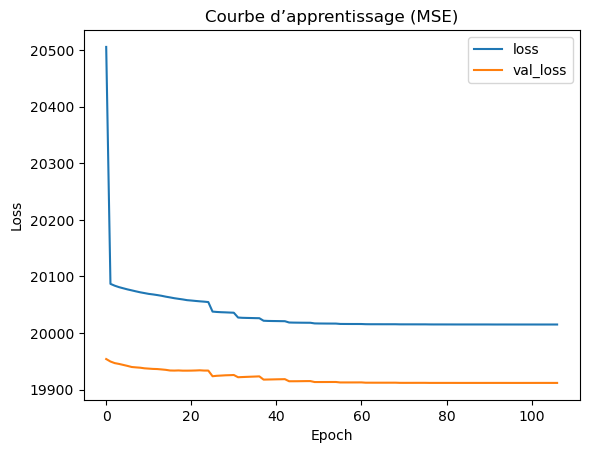

In [16]:
plt.figure()
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Courbe d’apprentissage (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 9) Évaluation du NN


In [17]:
pred_nn = nn.predict(X_test_nn).reshape(-1)

mae_nn = mean_absolute_error(y_test_nn, pred_nn)
mse_nn = mean_squared_error(y_test_nn, pred_nn)
r2_nn = r2_score(y_test_nn, pred_nn)

print('📌 Réseau de neurones — Résultats')
print('  MAE:', round(mae_nn, 4))
print('  MSE:', round(mse_nn, 4))
print('  R² :', round(r2_nn, 4))

6250/6250 ━━━━━━━━━━━━━━━━━━━━ 1s 214us/step
📌 Réseau de neurones — Résultats
  MAE: 122.4587
  MSE: 19995.084
  R² : -0.0008


## 10) Comparaison finale


In [18]:
results = pd.DataFrame([
    {'model': 'LinearRegression', 'MAE': mae_lr, 'MSE': mse_lr, 'R2': r2_lr},
    {'model': 'NeuralNetwork',    'MAE': mae_nn, 'MSE': mse_nn, 'R2': r2_nn},
])

display(results.sort_values('MAE'))

,model,MAE,MSE,R2
0,LinearRegression,122.431972,19981.192558,-0.000060
1,NeuralNetwork,122.458687,19995.083984,-0.000755


## 11) Visualisation — Prédictions vs Réel

Un graphique simple qui parle tout de suite.


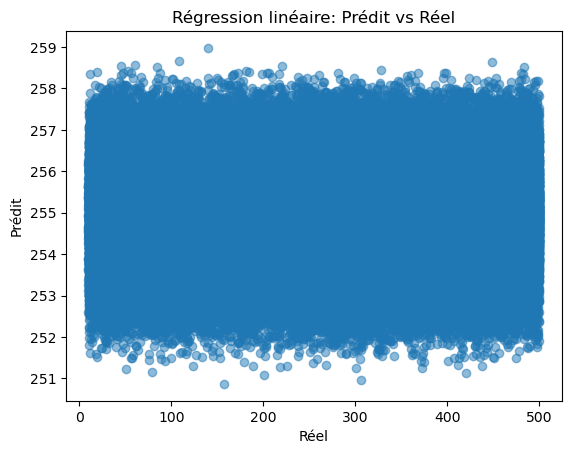

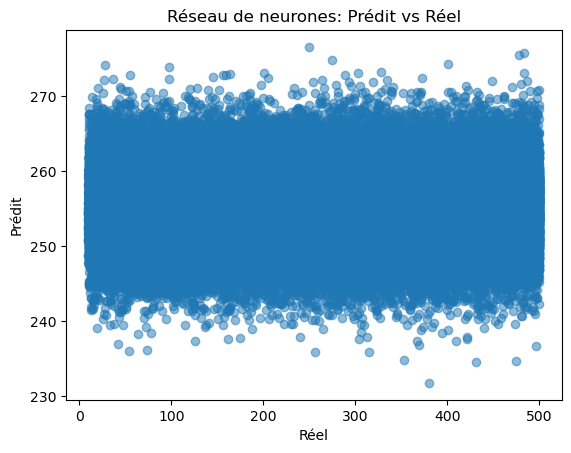

In [19]:
plt.figure()
plt.scatter(y_test, pred_lr, alpha=0.5)
plt.title('Régression linéaire: Prédit vs Réel')
plt.xlabel('Réel')
plt.ylabel('Prédit')
plt.show()

plt.figure()
plt.scatter(y_test, pred_nn, alpha=0.5)
plt.title('Réseau de neurones: Prédit vs Réel')
plt.xlabel('Réel')
plt.ylabel('Prédit')
plt.show()